In [1]:
%reset -f

In [2]:
import utils_preprocessing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Librairies for file openings
import os
import pickle
import glob

# Audio Librairies
import librosa
import librosa.display
import IPython.display as idp

#Librairies for better plotting
from itertools import cycle
sns.set_theme(style="white", palette=None)
#color palette
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

#tensorflow librairy
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow.keras as tf

2023-11-23 01:40:16.578138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_fsdd(spectrograms_path):
    x_train=[]
    for root,_,file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root,file_name)
            spectrogram= np.load(file_path) #(n_bins, n_frames)
            x_train.append(spectrogram)
    x_train= np.array(x_train)
    x_train=x_train[...,np.newaxis]
    return x_train

In [5]:
#files path:
files_path='data_saved2/spectrogram'

#loading data
x_train= load_fsdd(files_path)

In [6]:
x_train.shape

(30000, 256, 64, 1)

In [7]:
def get_Conv_Encoder(input_shape, latent_space_dim):
    encoder_input = layers.Input(shape=(input_shape), name="encoder_input")
    
    x = layers.Conv2D(32, (3,3), activation='relu',padding='same',name='Conv2D_1')(encoder_input)
    x = layers.BatchNormalization(name='BN_1')(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="MaxPool1")(x)
    x = layers.Conv2D(64, (3,3), activation='relu',padding='same',name='Conv2D_2')(x)
    x = layers.BatchNormalization(name='BN_2')(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="MaxPool2")(x)
    x = layers.Conv2D(128, (3,3), activation='relu',padding='same',name='Conv2D_3')(x)
    x = layers.BatchNormalization(name='BN_3')(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="MaxPool3")(x)
    x = layers.Conv2D(256, (3,3), activation='relu',padding='same',name='Conv2D_4')(x)
    x = layers.BatchNormalization(name='BN_4')(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="MaxPool4")(x)
    x = layers.Conv2D(512, (3,3), activation='relu',padding='same',name='Conv2D_5')(x)
    x = layers.BatchNormalization(name='BN_5')(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="MaxPool5")(x)

    
    shape_before_bottleneck= K.int_shape(x)[1:]
    x= layers.Flatten()(x)
    bottleneck= layers.Dense(latent_space_dim, name='bottleneck')(x)
    encoder = Model(encoder_input, bottleneck, name="encoder")
    
    return encoder, shape_before_bottleneck

In [8]:
def get_Conv_Decoder(latent_space_dim, shape_before_bottleneck):
    decoder_input = layers.Input(shape=(latent_space_dim), name="decoder_input")
    
    num_neurons = np.prod(shape_before_bottleneck)
    dense_layer = layers.Dense(num_neurons, name="decoder_dense")(decoder_input)
    x = layers.Reshape(shape_before_bottleneck)(dense_layer)

    x = layers.Conv2DTranspose(512, (3,3), activation='relu',strides=2,padding='same',name='Conv2DTrans_2')(x)
    x = layers.BatchNormalization(name='BN_6')(x)
    x = layers.Conv2DTranspose(256, (3,3), activation='relu',strides=2,padding='same',name='Conv2DTrans_3')(x)
    x = layers.BatchNormalization(name='BN_7')(x)
    x = layers.Conv2DTranspose(128, (3,3), activation='relu',strides=2,padding='same',name='Conv2DTrans_4')(x)
    x = layers.BatchNormalization(name='BN_8')(x)
    x = layers.Conv2DTranspose(64, (3,3), activation='relu',strides=2,padding='same',name='Conv2DTrans_5')(x)
    x = layers.BatchNormalization(name='BN_9')(x)
    x = layers.Conv2DTranspose(32, (3,3), activation='relu',strides=2,padding='same',name='Conv2DTrans_6')(x)
    x = layers.BatchNormalization(name='BN_10')(x)
    decoded = layers.Conv2DTranspose(1, (3,3), activation='sigmoid',padding='same',name='Conv2DTrans_7')(x)
    
    decoder = Model(decoder_input,decoded,name="decoder")
    return decoder

In [10]:
encoder_input=(256,64,1)
latent_space_dim=100
encoder,shape_before_bottleneck= get_Conv_Encoder(encoder_input,latent_space_dim)
decoder=get_Conv_Decoder(latent_space_dim,shape_before_bottleneck)

2023-11-23 01:41:48.960112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 64, 1)]      0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 256, 64, 32)       320       
                                                                 
 BN_1 (BatchNormalization)   (None, 256, 64, 32)       128       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 128, 32, 32)       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 128, 32, 64)       18496     
                                                                 
 BN_2 (BatchNormalization)   (None, 128, 32, 64)       256       
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 64, 16, 64)        0   

In [12]:
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 decoder_dense (Dense)       (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 2, 512)         0         
                                                                 
 Conv2DTrans_2 (Conv2DTransp  (None, 16, 4, 512)       2359808   
 ose)                                                            
                                                                 
 BN_6 (BatchNormalization)   (None, 16, 4, 512)        2048      
                                                                 
 Conv2DTrans_3 (Conv2DTransp  (None, 32, 8, 256)       1179904   
 ose)                                                      

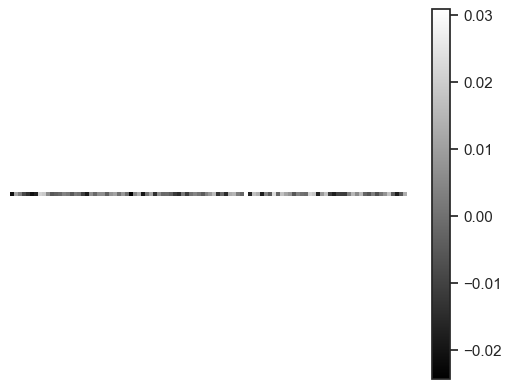

In [13]:
plt.imshow(encoder(x_train[0:1]),cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

In [14]:
def get_autoencoder(encoder,decoder):
    autoencoder_input= layers.Input(shape=encoder.input_shape[1:])
    encoded=encoder(autoencoder_input)
    decoded=decoder(encoded)
    autoencoder= Model(autoencoder_input,decoded,name="autoencoder")
    return autoencoder

In [15]:
autoencoder=get_autoencoder(encoder,decoder)

In [16]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 64, 1)]      0         
                                                                 
 encoder (Functional)        (None, 100)               2391268   
                                                                 
 decoder (Functional)        (None, 256, 64, 1)        4758657   
                                                                 
Total params: 7,149,925
Trainable params: 7,145,957
Non-trainable params: 3,968
_________________________________________________________________
None


In [19]:
autoencoder.compile(optimizer='adam',loss='mse')

In [18]:
hist = autoencoder.fit(x_train, x_train,batch_size=512, epochs=10,shuffle=True)

Epoch 1/10
59/59 [==============================] - 26378s 454s/step - loss: 0.0391 - accuracy: 0.1824
Epoch 2/10
59/59 [==============================] - 9642s 72s/step - loss: 0.0129 - accuracy: 0.1888
Epoch 3/10
41/59 [===================>..........] - ETA: 15:37 - loss: 0.0098 - accuracy: 0.1880


KeyboardInterrupt



In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()